# 03 从零实现卷积

> 用 NumPy 手写 2D 卷积，彻底理解底层原理

---

## 📚 学习目标

在本章结束后，你将能够：

- [ ] 用循环实现最基本的 2D 卷积
- [ ] 实现带 padding 和 stride 的卷积
- [ ] 实现多通道卷积
- [ ] 实现批量处理
- [ ] 验证实现的正确性

## 🔍 前置知识

请确保已完成：

- ✅ **02_convolution_math.ipynb** - 理解卷积的数学公式
- ✅ **NumPy 熟练使用** - 数组切片、广播

In [1]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import time

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

np.random.seed(42)
print("环境准备完成！")

环境准备完成！


---

## 💻 版本1：最直观的 4 层循环实现

先实现最简单的版本：无 padding，stride=1，单通道。

**对应公式**：

$$(I * K)[i, j] = \sum_{m=0}^{k_h-1} \sum_{n=0}^{k_w-1} I[i+m, j+n] \cdot K[m, n]$$

In [2]:
# ============================================================
# 版本1：最直观的实现（4层循环）
# ============================================================

def conv2d_v1(image, kernel):
    """
    2D 卷积的朴素实现（最直观版本）
    
    对应公式:
        (I * K)[i,j] = Σ_m Σ_n I[i+m, j+n] · K[m, n]
    
    参数:
        image: 输入图像, shape (H, W)
               H = 图像高度, W = 图像宽度
        kernel: 卷积核, shape (k_h, k_w)
                k_h = 核高度, k_w = 核宽度
    
    返回:
        output: 卷积结果, shape (H-k_h+1, W-k_w+1)
    
    注意:
        - 无 padding (valid mode)
        - stride = 1
    """
    # ========================================
    # 第1步：获取输入和核的形状
    # ========================================
    H, W = image.shape      # 图像的高和宽
    k_h, k_w = kernel.shape  # 核的高和宽
    
    # ========================================
    # 第2步：计算输出尺寸
    # 公式：H_out = H - k_h + 1
    # ========================================
    out_h = H - k_h + 1
    out_w = W - k_w + 1
    
    # ========================================
    # 第3步：初始化输出矩阵
    # ========================================
    output = np.zeros((out_h, out_w))
    
    # ========================================
    # 第4步：4层循环计算卷积
    # 外两层：遍历输出的每个位置 (i, j)
    # 内两层：遍历核内的每个位置 (m, n)
    # ========================================
    for i in range(out_h):      # 输出的行索引
        for j in range(out_w):  # 输出的列索引
            
            # 累加器：存储当前位置的卷积结果
            total = 0.0
            
            for m in range(k_h):      # 核的行索引
                for n in range(k_w):  # 核的列索引
                    # 对应公式中的 I[i+m, j+n] · K[m, n]
                    total += image[i + m, j + n] * kernel[m, n]
            
            output[i, j] = total
    
    return output

输入图像 (5×5):
[[ 1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10.]
 [11. 12. 13. 14. 15.]
 [16. 17. 18. 19. 20.]
 [21. 22. 23. 24. 25.]]

卷积核 (3×3):
[[-1. -1. -1.]
 [-1.  8. -1.]
 [-1. -1. -1.]]

输出 (3×3):
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


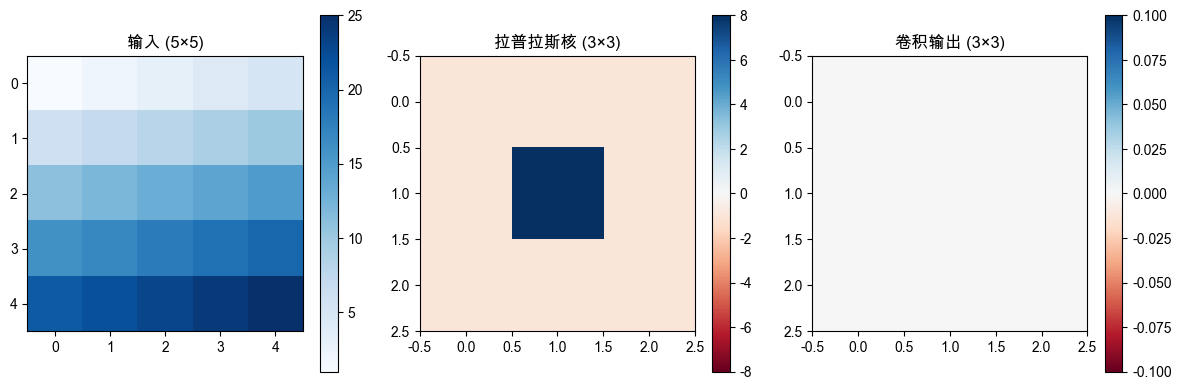

In [3]:
# ============================================================
# 测试版本1
# ============================================================

# 创建测试图像 (5×5)
test_image = np.array([
    [1, 2, 3, 4, 5],
    [6, 7, 8, 9, 10],
    [11, 12, 13, 14, 15],
    [16, 17, 18, 19, 20],
    [21, 22, 23, 24, 25]
], dtype=float)

# 边缘检测核 (3×3)
edge_kernel = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
], dtype=float)

# 执行卷积
result_v1 = conv2d_v1(test_image, edge_kernel)

print("输入图像 (5×5):")
print(test_image)
print("\n卷积核 (3×3):")
print(edge_kernel)
print(f"\n输出 (3×3):")
print(result_v1)

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

im0 = axes[0].imshow(test_image, cmap='Blues')
axes[0].set_title('输入 (5×5)')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(edge_kernel, cmap='RdBu', vmin=-8, vmax=8)
axes[1].set_title('拉普拉斯核 (3×3)')
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(result_v1, cmap='RdBu')
axes[2].set_title('卷积输出 (3×3)')
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

---

## 💻 版本2：优化的 2 层循环实现

利用 NumPy 的切片和逐元素运算，去掉内层两个循环。

In [4]:
# ============================================================
# 版本2：优化的实现（2层循环）
# ============================================================

def conv2d_v2(image, kernel):
    """
    2D 卷积的优化实现（2层循环）
    
    优化思路:
        - 不再逐个元素计算
        - 直接切片出感受野区域
        - 使用 NumPy 的逐元素乘法和求和
    
    参数:
        image: 输入图像, shape (H, W)
        kernel: 卷积核, shape (k_h, k_w)
    
    返回:
        output: 卷积结果
    """
    H, W = image.shape
    k_h, k_w = kernel.shape
    
    out_h = H - k_h + 1
    out_w = W - k_w + 1
    
    output = np.zeros((out_h, out_w))
    
    # ========================================
    # 只需要 2 层循环：遍历输出位置
    # ========================================
    for i in range(out_h):
        for j in range(out_w):
            # 切片提取感受野（receptive field）
            # 这是当前位置对应的输入区域
            receptive_field = image[i:i+k_h, j:j+k_w]
            
            # 逐元素相乘，然后求和
            # 等价于 Σ_m Σ_n I[i+m, j+n] · K[m, n]
            output[i, j] = np.sum(receptive_field * kernel)
    
    return output

In [5]:
# ============================================================
# 验证版本2与版本1结果一致
# ============================================================

result_v2 = conv2d_v2(test_image, edge_kernel)

print("版本1结果:")
print(result_v1)
print("\n版本2结果:")
print(result_v2)
print(f"\n两个版本结果是否一致: {np.allclose(result_v1, result_v2)}")

版本1结果:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

版本2结果:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

两个版本结果是否一致: True


---

## 💻 版本3：添加 Padding 和 Stride

In [6]:
# ============================================================
# 版本3：支持 padding 和 stride
# ============================================================

def conv2d_v3(image, kernel, padding=0, stride=1):
    """
    2D 卷积（支持 padding 和 stride）
    
    参数:
        image: 输入图像, shape (H, W)
        kernel: 卷积核, shape (k_h, k_w)
        padding: 零填充的像素数, 默认 0
        stride: 滑动步幅, 默认 1
    
    返回:
        output: 卷积结果
    
    输出尺寸公式:
        H_out = floor((H + 2*padding - k_h) / stride) + 1
    """
    H, W = image.shape
    k_h, k_w = kernel.shape
    
    # ========================================
    # 第1步：添加 padding
    # np.pad 在数组边缘填充指定值
    # ========================================
    if padding > 0:
        # pad_width=padding 表示上下左右都填充 padding 个 0
        image_padded = np.pad(image, pad_width=padding, 
                              mode='constant', constant_values=0)
    else:
        image_padded = image
    
    # 更新尺寸（填充后的尺寸）
    H_padded, W_padded = image_padded.shape
    
    # ========================================
    # 第2步：计算输出尺寸
    # ========================================
    out_h = (H_padded - k_h) // stride + 1
    out_w = (W_padded - k_w) // stride + 1
    
    output = np.zeros((out_h, out_w))
    
    # ========================================
    # 第3步：卷积计算（考虑 stride）
    # ========================================
    for i in range(out_h):
        for j in range(out_w):
            # 注意：实际位置要乘以 stride
            i_start = i * stride
            j_start = j * stride
            
            receptive_field = image_padded[i_start:i_start+k_h, 
                                           j_start:j_start+k_w]
            output[i, j] = np.sum(receptive_field * kernel)
    
    return output

In [7]:
# ============================================================
# 测试 padding 和 stride
# ============================================================

# 测试 same padding (输入输出尺寸相同)
# 对于 3×3 核，padding=1 实现 same convolution
result_same = conv2d_v3(test_image, edge_kernel, padding=1, stride=1)

print("输入尺寸:", test_image.shape)
print("\nValid convolution (padding=0):")
print(f"输出尺寸: {conv2d_v3(test_image, edge_kernel, padding=0).shape}")

print("\nSame convolution (padding=1):")
print(f"输出尺寸: {result_same.shape}")

print("\nStride=2 convolution:")
result_stride2 = conv2d_v3(test_image, edge_kernel, padding=1, stride=2)
print(f"输出尺寸: {result_stride2.shape}")

输入尺寸: (5, 5)

Valid convolution (padding=0):
输出尺寸: (3, 3)

Same convolution (padding=1):
输出尺寸: (5, 5)

Stride=2 convolution:
输出尺寸: (3, 3)


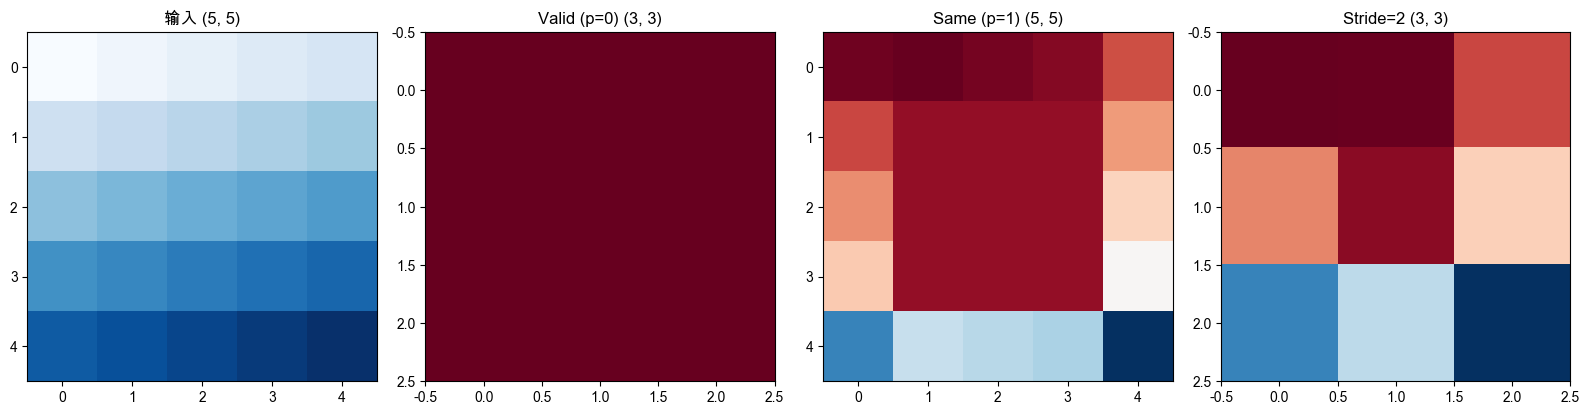

In [8]:
# ============================================================
# 可视化 padding 效果
# ============================================================

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# 原始
axes[0].imshow(test_image, cmap='Blues')
axes[0].set_title(f'输入 {test_image.shape}')

# Valid
valid = conv2d_v3(test_image, edge_kernel, padding=0)
axes[1].imshow(valid, cmap='RdBu')
axes[1].set_title(f'Valid (p=0) {valid.shape}')

# Same
same = conv2d_v3(test_image, edge_kernel, padding=1)
axes[2].imshow(same, cmap='RdBu')
axes[2].set_title(f'Same (p=1) {same.shape}')

# Stride=2
strided = conv2d_v3(test_image, edge_kernel, padding=1, stride=2)
axes[3].imshow(strided, cmap='RdBu')
axes[3].set_title(f'Stride=2 {strided.shape}')

plt.tight_layout()
plt.show()

---

## 💻 版本4：多通道卷积

实际的 CNN 需要处理多通道输入（如 RGB 图像）。

In [9]:
# ============================================================
# 版本4：多通道卷积
# ============================================================

def conv2d_multichannel(image, kernel, bias=0, padding=0, stride=1):
    """
    多通道 2D 卷积
    
    一个卷积核处理所有输入通道，产生一个输出通道。
    
    参数:
        image: 输入图像, shape (C_in, H, W)
               C_in = 输入通道数
        kernel: 卷积核, shape (C_in, k_h, k_w)
                必须与输入通道数匹配
        bias: 偏置项, 标量
        padding: 零填充
        stride: 步幅
    
    返回:
        output: shape (H_out, W_out) - 单通道输出
    
    公式:
        O[i,j] = Σ_c Σ_m Σ_n I[c, i+m, j+n] · K[c, m, n] + b
    """
    C_in, H, W = image.shape
    C_kernel, k_h, k_w = kernel.shape
    
    # 验证通道数匹配
    assert C_in == C_kernel, f"通道数不匹配: 输入{C_in} vs 核{C_kernel}"
    
    # ========================================
    # 第1步：对每个通道添加 padding
    # ========================================
    if padding > 0:
        # 只在 H 和 W 维度填充，不在通道维度
        image_padded = np.pad(image, 
                              pad_width=((0, 0), (padding, padding), (padding, padding)),
                              mode='constant', constant_values=0)
    else:
        image_padded = image
    
    _, H_padded, W_padded = image_padded.shape
    
    # ========================================
    # 第2步：计算输出尺寸
    # ========================================
    out_h = (H_padded - k_h) // stride + 1
    out_w = (W_padded - k_w) // stride + 1
    
    output = np.zeros((out_h, out_w))
    
    # ========================================
    # 第3步：卷积计算
    # 对所有通道求和
    # ========================================
    for i in range(out_h):
        for j in range(out_w):
            i_start = i * stride
            j_start = j * stride
            
            # 所有通道的感受野 (C_in, k_h, k_w)
            receptive_field = image_padded[:, i_start:i_start+k_h, 
                                              j_start:j_start+k_w]
            
            # 逐元素相乘，然后对所有维度求和
            output[i, j] = np.sum(receptive_field * kernel) + bias
    
    return output

[[-0.84393214 -0.70907243 -3.36179121]
 [-1.44703292  5.36393247 -2.31297614]
 [ 0.3006852   1.82455638  9.8581707 ]]
RGB 图像形状: (3, 4, 4)
RGB 卷积核形状: (3, 2, 2)
输出形状: (3, 3)


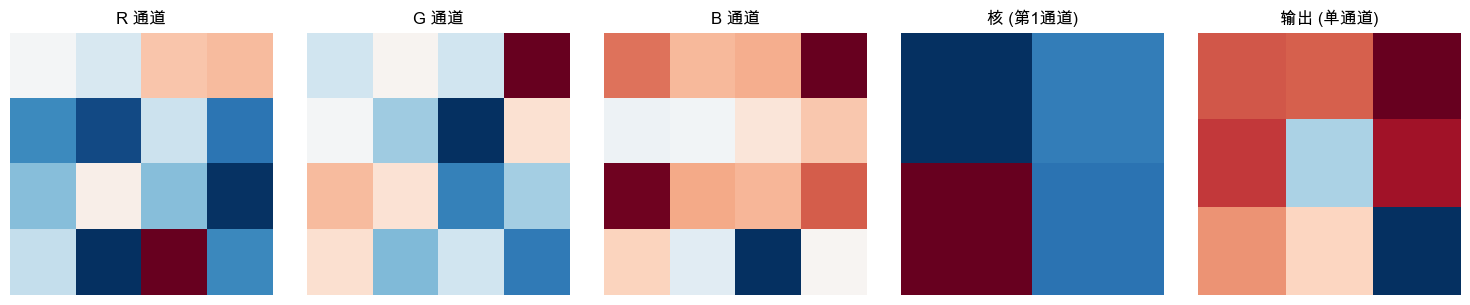

In [11]:
# ============================================================
# 测试多通道卷积
# ============================================================

# 创建 RGB 图像 (3, 4, 4)
rgb_image = np.random.randn(3, 4, 4)

# 创建 3 通道的核 (3, 2, 2)
rgb_kernel = np.random.randn(3, 2, 2)

# 执行多通道卷积
result_mc = conv2d_multichannel(rgb_image, rgb_kernel, bias=0.5)
print(result_mc)

print("RGB 图像形状:", rgb_image.shape)
print("RGB 卷积核形状:", rgb_kernel.shape)
print("输出形状:", result_mc.shape)

# 可视化
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# 显示 RGB 三个通道
for c, color in enumerate(['R', 'G', 'B']):
    axes[c].imshow(rgb_image[c], cmap='RdBu')
    axes[c].set_title(f'{color} 通道')
    axes[c].axis('off')

# 显示核（取第一个通道作为示例）
axes[3].imshow(rgb_kernel[0], cmap='RdBu')
axes[3].set_title('核 (第1通道)')
axes[3].axis('off')

# 显示输出
axes[4].imshow(result_mc, cmap='RdBu')
axes[4].set_title('输出 (单通道)')
axes[4].axis('off')

plt.tight_layout()
plt.show()

---

## 💻 版本5：完整的卷积层

支持多个输出通道和批量处理。

In [12]:
# ============================================================
# 版本5：完整的卷积层实现
# ============================================================

def conv2d_full(images, kernels, biases=None, padding=0, stride=1):
    """
    完整的 2D 卷积层实现
    
    支持:
        - 批量处理 (batch)
        - 多输入通道
        - 多输出通道（多个卷积核）
    
    参数:
        images: 输入批量, shape (N, C_in, H, W)
                N = batch size（批量大小）
                C_in = 输入通道数
                H, W = 高度和宽度
        kernels: 卷积核, shape (C_out, C_in, k_h, k_w)
                 C_out = 输出通道数（核的数量）
        biases: 偏置, shape (C_out,) 或 None
        padding: 零填充
        stride: 步幅
    
    返回:
        output: shape (N, C_out, H_out, W_out)
    """
    N, C_in, H, W = images.shape
    C_out, C_in_k, k_h, k_w = kernels.shape
    
    # 验证通道数匹配
    assert C_in == C_in_k, f"通道数不匹配: 输入{C_in} vs 核{C_in_k}"
    
    # 处理偏置
    if biases is None:
        biases = np.zeros(C_out)
    
    # ========================================
    # 第1步：添加 padding
    # ========================================
    if padding > 0:
        images_padded = np.pad(images,
                               pad_width=((0, 0), (0, 0), 
                                          (padding, padding), (padding, padding)),
                               mode='constant', constant_values=0)
    else:
        images_padded = images
    
    _, _, H_padded, W_padded = images_padded.shape
    
    # ========================================
    # 第2步：计算输出尺寸
    # ========================================
    out_h = (H_padded - k_h) // stride + 1
    out_w = (W_padded - k_w) // stride + 1
    
    output = np.zeros((N, C_out, out_h, out_w))
    
    # ========================================
    # 第3步：卷积计算
    # 遍历: batch -> 输出通道 -> 空间位置
    # ========================================
    for n in range(N):              # 遍历 batch
        for c_out in range(C_out):  # 遍历输出通道
            for i in range(out_h):  # 遍历输出高度
                for j in range(out_w):  # 遍历输出宽度
                    i_start = i * stride
                    j_start = j * stride
                    
                    # 感受野: (C_in, k_h, k_w)
                    receptive_field = images_padded[
                        n, :, 
                        i_start:i_start+k_h, 
                        j_start:j_start+k_w
                    ]
                    
                    # 当前核: (C_in, k_h, k_w)
                    kernel = kernels[c_out]
                    
                    # 卷积 + 偏置
                    output[n, c_out, i, j] = (
                        np.sum(receptive_field * kernel) + biases[c_out]
                    )
    
    return output

In [13]:
# ============================================================
# 测试完整卷积层
# ============================================================

# 模拟一个 batch：4 张 RGB 图像，每张 8×8
batch_images = np.random.randn(4, 3, 8, 8)  # (N, C_in, H, W)

# 16 个卷积核，每个处理 3 个输入通道，大小 3×3
conv_kernels = np.random.randn(16, 3, 3, 3)  # (C_out, C_in, k_h, k_w)

# 16 个偏置
conv_biases = np.random.randn(16)

# 执行卷积
batch_output = conv2d_full(batch_images, conv_kernels, conv_biases, 
                           padding=1, stride=1)

print("输入形状:", batch_images.shape)
print("  - Batch size: 4")
print("  - 输入通道: 3 (RGB)")
print("  - 空间尺寸: 8×8")
print()
print("卷积核形状:", conv_kernels.shape)
print("  - 输出通道: 16")
print("  - 输入通道: 3")
print("  - 核大小: 3×3")
print()
print("输出形状:", batch_output.shape)
print("  - Batch size: 4")
print("  - 输出通道: 16")
print("  - 空间尺寸: 8×8 (same padding)")

输入形状: (4, 3, 8, 8)
  - Batch size: 4
  - 输入通道: 3 (RGB)
  - 空间尺寸: 8×8

卷积核形状: (16, 3, 3, 3)
  - 输出通道: 16
  - 输入通道: 3
  - 核大小: 3×3

输出形状: (4, 16, 8, 8)
  - Batch size: 4
  - 输出通道: 16
  - 空间尺寸: 8×8 (same padding)


---

## ✅ 验证：与 SciPy 对比

In [14]:
# ============================================================
# 与 SciPy 的结果对比验证
# ============================================================

# 创建测试数据
test_img = np.random.randn(10, 10)
test_kernel = np.random.randn(3, 3)

# 我们的实现
our_result = conv2d_v3(test_img, test_kernel, padding=0, stride=1)

# SciPy 的实现（注意：correlate2d 是互相关，和深度学习的"卷积"一致）
scipy_result = signal.correlate2d(test_img, test_kernel, mode='valid')

print("我们的结果形状:", our_result.shape)
print("SciPy 结果形状:", scipy_result.shape)
print()
print("结果差异（应该接近 0）:")
print(f"最大绝对差异: {np.max(np.abs(our_result - scipy_result)):.2e}")
print(f"结果是否一致: {np.allclose(our_result, scipy_result)}")

我们的结果形状: (8, 8)
SciPy 结果形状: (8, 8)

结果差异（应该接近 0）:
最大绝对差异: 1.78e-15
结果是否一致: True


---

## ⏱️ 性能对比

In [15]:
# ============================================================
# 性能对比
# ============================================================

# 较大的测试数据
large_img = np.random.randn(64, 64)
large_kernel = np.random.randn(3, 3)

# 版本1：4层循环
start = time.time()
for _ in range(10):
    _ = conv2d_v1(large_img, large_kernel)
time_v1 = (time.time() - start) / 10 * 1000

# 版本2：2层循环
start = time.time()
for _ in range(10):
    _ = conv2d_v2(large_img, large_kernel)
time_v2 = (time.time() - start) / 10 * 1000

# 版本3：带 padding/stride
start = time.time()
for _ in range(10):
    _ = conv2d_v3(large_img, large_kernel, padding=1)
time_v3 = (time.time() - start) / 10 * 1000

# SciPy
start = time.time()
for _ in range(10):
    _ = signal.correlate2d(large_img, large_kernel, mode='valid')
time_scipy = (time.time() - start) / 10 * 1000

print("性能对比 (64×64 图像，3×3 核，10次平均)")
print("=" * 50)
print(f"版本1 (4层循环):  {time_v1:.2f} ms")
print(f"版本2 (2层循环):  {time_v2:.2f} ms")
print(f"版本3 (带padding): {time_v3:.2f} ms")
print(f"SciPy:             {time_scipy:.2f} ms")
print()
print(f"💡 SciPy 比我们的实现快约 {time_v2/time_scipy:.0f} 倍")
print("   这是因为 SciPy 用了优化的 C 代码")

性能对比 (64×64 图像，3×3 核，10次平均)
版本1 (4层循环):  8.07 ms
版本2 (2层循环):  6.25 ms
版本3 (带padding): 6.74 ms
SciPy:             0.05 ms

💡 SciPy 比我们的实现快约 134 倍
   这是因为 SciPy 用了优化的 C 代码


---

## 📝 本章小结

### 实现版本回顾

| 版本 | 特点 | 循环数 |
|------|------|--------|
| V1 | 最直观，完全按公式 | 4 层 |
| V2 | 利用 NumPy 切片 | 2 层 |
| V3 | 支持 padding/stride | 2 层 |
| V4 | 多通道输入 | 2 层 |
| V5 | 完整卷积层 | 4 层（含 batch 和输出通道）|

### 关键代码模式

```python
# 核心卷积操作
receptive_field = image[i:i+k_h, j:j+k_w]
output[i, j] = np.sum(receptive_field * kernel) + bias
```

### 重要提醒

- 这些实现用于**教学理解**
- 实际使用请用 PyTorch/TensorFlow（它们用 CUDA 加速）

---

## 🎯 练习

### 练习 1：实现转置卷积

转置卷积（Transposed Convolution）用于上采样，将 2×2 变成 4×4。

### 练习 2：实现空洞卷积

空洞卷积（Dilated Convolution）在核元素之间插入空洞，增大感受野。

### 练习 3：优化

使用 im2col 技术将卷积转换为矩阵乘法，提升性能。

---

## 🚀 下一步

继续学习 **04_pooling_layers.ipynb** - 池化层详解

你将学到：
- 最大池化和平均池化
- 从零实现池化层
- 池化的作用